<h1 style="font-size:240%; color:blue; text-align:center; line-height:45px;"> 2. Transformadas sobre Imágenes </h1>

<p style="font-size:135%;">Las transformadas en general son usadas para pasar de un dominio a otro, el cambio de dominio permite realizar algunas operaciones con mayor facilidad. El dominio mas utilizado en las transformaciones, frecuencia, permite filtrar, comprimir, analizar armonicos entre otras operaciones. Para el caso del taller se analizaran las funciones de compresion y atenuacion del ruido.</p>

<p style="font-size:135%;">Las librerias y imagen de prueba usadas se muestran a continuacion</p>

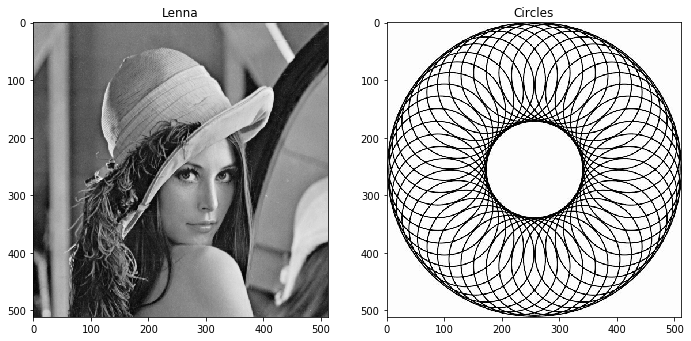

In [55]:
from matplotlib import pyplot as plt
from IPython.display import Image
import numpy as np
from numpy.linalg import inv
from scipy.fftpack import dst, idst
import pywt
import cv2
import math
import time

img = cv2.imread("Figures/Lenna.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

img2 = cv2.imread("Figures/Circles.png")
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

plt.figure(1)
plt.subplots_adjust(left=0.0, right=1.5, bottom=0.0, top=1.5)
plt.subplot(121) ,plt.imshow(img, cmap='gray')
plt.title('Lenna')
plt.subplot(122) ,plt.imshow(img2, cmap='gray')
plt.title('Circles')
plt.show()



<h1 style="font-size:180%; color:blue; text-align:center; line-height:45px;"> 2.1 Transformada de Walsh-Hadamard </h1>

<p style="font-size:135%;">La transformanda de Walsh-Hadamard a diferencia de la transformada de Fourier usa ondas rectangulares en el rango de $(-1,+1)$ contrario a las usualmente usadas ondas sinusoidales. Aunque cumple con las propiedades de ser simetrica y ortogonal, ademas su calculo es completamente real. Su expresion de transformación e inversa se ilustran a continuación.</p>

<ul style="font-size:150%; text-align:center;">
    $WH(u,v) = \frac{1}{N} \sum_{x=0}^{N} \sum_{y=0}^{N} f(x,y)(-1)^{\sum_{i=0}^{n-1} b_i(x) p_i(u)+b_i(y) p_i(v)}$
</ul>

<ul style="font-size:150%; text-align:center;">
    $f(x,y) = \frac{1}{N} \sum_{x=0}^{N} \sum_{y=0}^{N} WH(u,v)(-1)^{\sum_{i=0}^{n-1} b_i(x) p_i(u)+b_i(y) p_i(v)}$
</ul>

<p style="font-size:135%;">
Estas expresiones pueden reducirse, hallando los coeficiente de transformacion a partir de una matriz de unos con un patron de signos, por ejemplo para el caso bidimensional basico se tiene.
</p>

<ul style="font-size:125%; text-align:center;">
$H_2 = \begin{bmatrix}
1 & 1\\ 
-1 & 1
\end{bmatrix}$
</ul>

<p style="font-size:135%;">
El patrón que sigue para coeficientes mayores es el siguiente.
</p>

<ul style="font-size:125%; text-align:center;">
$H_{2N} = \begin{bmatrix}
H_N & H_N\\ 
H_N & -H_N
\end{bmatrix}$
</ul>

<p style="font-size:135%;">
Como resultado del calculo anticipado de los coeficientes el calculo de la transformada se vuelve mucho mas rapido, reduciendose a una simple multiplicación de matrices.
</p>

<ul style="font-size:125%; text-align:center;">
$A = \frac{1}{\sqrt{N}} * H_N \Rightarrow T = AFA^{-1}$
</ul>

/home/invictus/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in log
/home/invictus/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in log


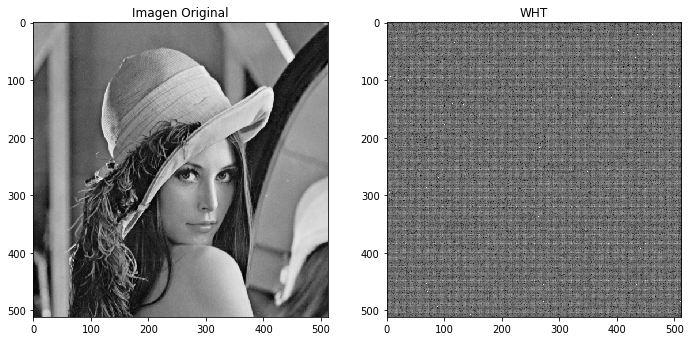

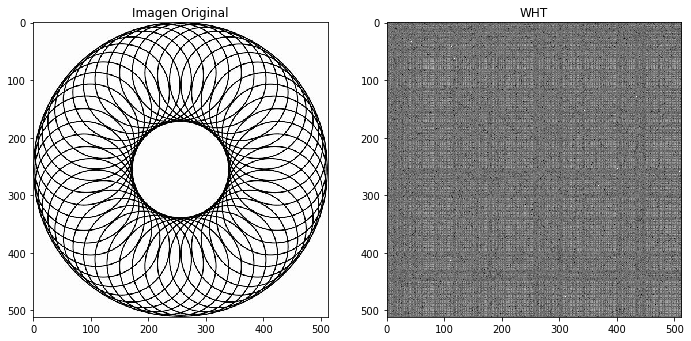

In [2]:
def H(n):    
    if n == 2:
        return np.matrix([[1, 1], [1,-1]])
    else:
        h = np.zeros((n,n))
        m = int(n/2)
        h[0:m,0:m] = H(m)
        h[m:n,0:m] = H(m)
        h[0:m,m:n] = H(m)
        h[m:n,m:n] = -H(m)
        return h
        
def WHT(img):
    n = img.shape[0]    
    h = H(n)
    ih = inv(h)
    T = np.dot(h, np.dot(img, ih))*1/(n)
    return T

def iWHT(T):
    n = T.shape[0]    
    h = H(n)
    ih = inv(h)
    nImg = np.dot(ih, np.dot(T, h))*1/(n)
    return nImg

tImg = WHT(img)
tImg = 20*np.log(np.abs(tImg))
plt.figure(1)
plt.subplots_adjust(left=0.0, right=1.5, bottom=0.0, top=1.5)
plt.subplot(121) , plt.imshow(img, cmap='gray')
plt.title('Imagen Original')
plt.subplot(122) , plt.imshow(tImg, cmap='gray')
plt.title('WHT')

tImg2 = WHT(img2)
reimg2 = iWHT(tImg2)
tImg2 = 20*np.log(np.abs(tImg2))
plt.figure(2)
plt.subplots_adjust(left=0.0, right=1.5, bottom=0.0, top=1.5)
plt.subplot(121) , plt.imshow(img2, cmap='gray')
plt.title('Imagen Original')
plt.subplot(122) , plt.imshow(tImg2, cmap='gray')
plt.title('WHT')

plt.show()



<h1 style="font-size:180%; color:blue; text-align:center; line-height:45px;"> 2.2 Compresión de imagenes </h1>
<h1 style="font-size:150%; color:blue; text-align:left; line-height:45px;"> 2.2.1 Transformada de Fourier </h1>

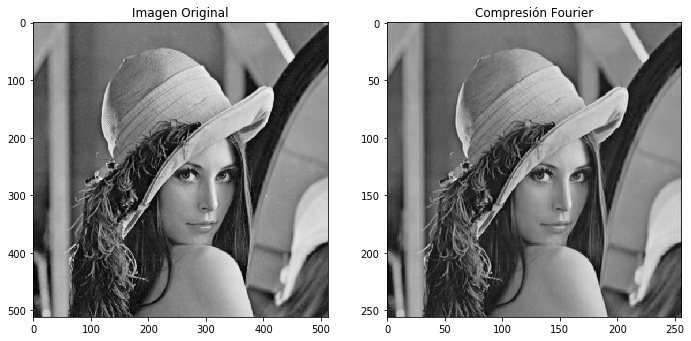

Tiempo de ejecución =  0.052448272705078125


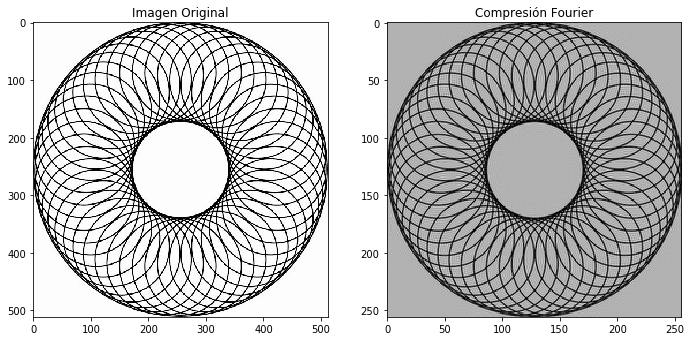

Tiempo de ejecución =  0.024624347686767578


In [3]:
def FourierCompression(img):
       
    h = img.shape[0]
    w = img.shape[1]
    
    
    cmpImage = np.zeros((h, w), np.uint8)  
    

    fft = np.fft.fft2(img)
    fshift = np.fft.fftshift(fft)
    fCmp = fshift[int(h/2-h/4):int(h/2+h/4), int(w/2-w/4):int(w/2+w/4)]
    magnitude_spectrum = 20*np.log(np.abs(fCmp))
    
    ishift = np.fft.ifftshift(fCmp)
    cmp = np.fft.ifft2(ishift)
    cmp = np.abs(cmp)
    
    return cmp

start = time.time()
cmp = FourierCompression(img)
end = time.time()
exeTime = end - start

plt.figure(1)
plt.subplots_adjust(left=0.0, right=1.5, bottom=0.0, top=1.5)
plt.subplot(121) , plt.imshow(img, cmap='gray')
plt.title('Imagen Original')
plt.subplot(122) , plt.imshow(cmp, cmap='gray')
plt.title('Compresión Fourier')
plt.show()
print('Tiempo de ejecución = ', exeTime)

start = time.time()
cmp2 = FourierCompression(img2)
end = time.time()
exeTime = end - start

plt.figure(2)
plt.subplots_adjust(left=0.0, right=1.5, bottom=0.0, top=1.5)
plt.subplot(121) , plt.imshow(img2, cmap='gray')
plt.title('Imagen Original')
plt.subplot(122) , plt.imshow(cmp2, cmap='gray')
plt.title('Compresión Fourier')
plt.show()
print('Tiempo de ejecución = ', exeTime)

<h1 style="font-size:150%; color:blue; text-align:left; line-height:45px;"> 2.2.2 Transformada del Coseno (Algoritmo JPG) </h1>

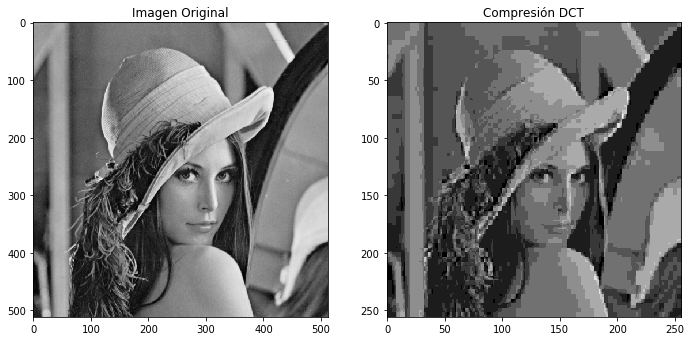

Tiempo de ejecución =  0.10674619674682617


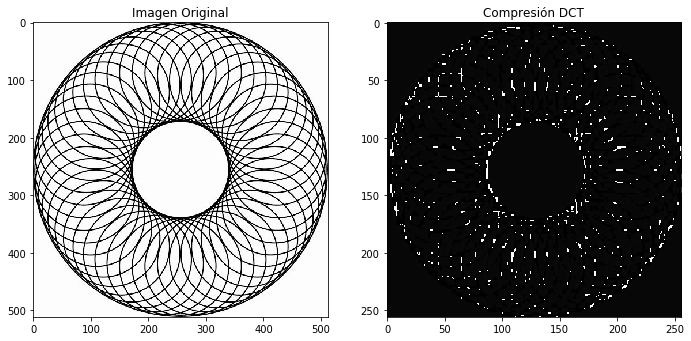

Tiempo de ejecución =  0.11233878135681152


In [4]:
def JPEG(img):
    
    qMtx = np.matrix('16 11 10 16 24 40 51 61;\
                      12 12 14 19 26 58 60 55;\
                      14 13 16 24 40 57 69 56;\
                      14 17 22 29 51 87 80 62;\
                      18 22 37 56 68 109 103 77;\
                      24 35 55 64 81 104 103 92;\
                      49 64 78 77 103 121 120 101;\
                      72 92 95 98 112 100 103 99').astype('float32')
    n = len(qMtx)    
    h = img.shape[0]
    w = img.shape[1]
    
    nc = int(len(qMtx)/2)
    hc = math.floor(h/2)
    wc = math.floor(w/2)
    
    cmpImage = np.zeros((hc, wc), np.uint8)  
    for i in range(0, math.floor(h/n)):
        for j in range(0, math.floor(w/n)):
            sample = img[i*n:i*n+8,j*n:j*n+8]
            imf = np.float32(sample)/255.0
            dct = cv2.dct(imf)
            qDct = (dct*127/qMtx).astype(int)
            idct = cv2.idct(np.float32(qDct)/255.0) 
            cmpImage[i*nc:i*nc+4,j*nc:j*nc+4] = (idct[0:4,0:4]*255).astype(int)
    return cmpImage

start = time.time()
cmp = JPEG(img)
end = time.time()
exeTime = end - start

plt.figure(1)
plt.subplots_adjust(left=0.0, right=1.5, bottom=0.0, top=1.5)
plt.subplot(121) , plt.imshow(img, cmap='gray')
plt.title('Imagen Original')
plt.subplot(122) , plt.imshow(cmp, cmap='gray')
plt.title('Compresión DCT')
plt.show()

print('Tiempo de ejecución = ', exeTime)

start = time.time()
cmp2 = JPEG(img2)
end = time.time()
exeTime = end - start

plt.figure(2)
plt.subplots_adjust(left=0.0, right=1.5, bottom=0.0, top=1.5)
plt.subplot(121) , plt.imshow(img2, cmap='gray')
plt.title('Imagen Original')
plt.subplot(122) , plt.imshow(cmp2, cmap='gray')
plt.title('Compresión DCT')
plt.show()

print('Tiempo de ejecución = ', exeTime)



<h1 style="font-size:150%; color:blue; text-align:left; line-height:45px;"> 2.2.3 Transformada Seno </h1>

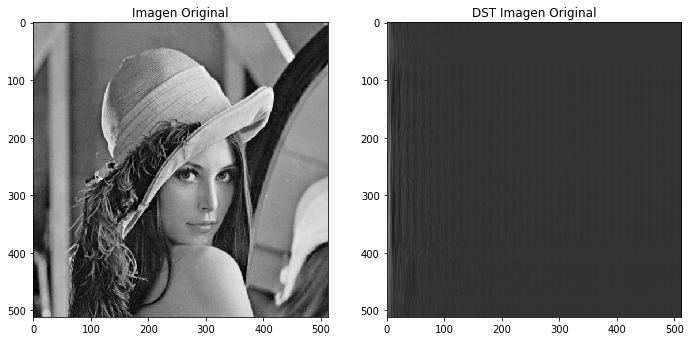

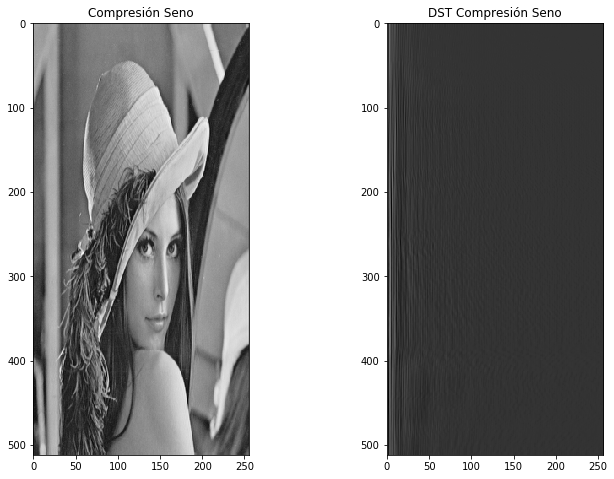

In [67]:
def cDST(img):
    T = dst(img)
    n = int(len(img)/2)
    rT = T[0:len(img),0:n]
    return idst(rT)
    
cmp = cDST(img)
    
plt.figure(1)
plt.subplots_adjust(left=0.0, right=1.5, bottom=0.0, top=1.5)
plt.subplot(121) , plt.imshow(img, cmap='gray')
plt.title('Imagen Original')
plt.subplot(122) , plt.imshow(dst(img), cmap='gray')
plt.title('DST Imagen Original')

plt.figure(2)
plt.subplots_adjust(left=0.0, right=1.5, bottom=0.0, top=1.5)
plt.subplot(121) , plt.imshow(cmp, cmap='gray')
plt.title('Compresión Seno')
plt.subplot(122) , plt.imshow(dst(cmp), cmap='gray')
plt.title('DST Compresión Seno')
plt.show()    
    

<h1 style="font-size:150%; color:blue; text-align:left; line-height:45px;"> 2.2.4 Wavelet </h1>

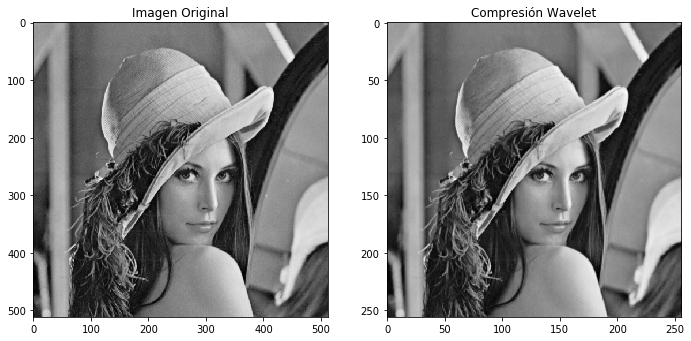

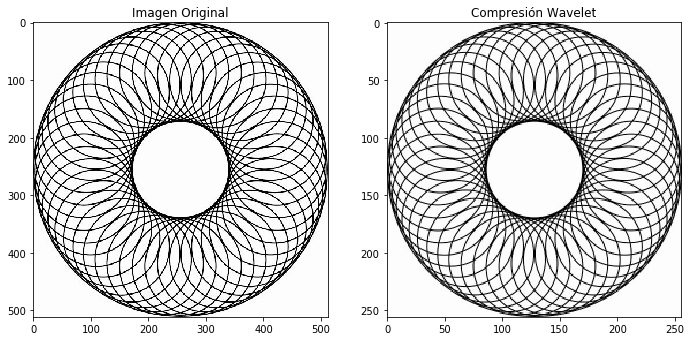

Tiempo de ejecución =  0.004615068435668945


In [5]:
def w2d(img, mode='haar', level=1):    
    coeffs=pywt.wavedec2(img, mode, level=level)
    return coeffs[0]

dwtImg = w2d(img)

start = time.time()
cmp = w2d(img)
end = time.time()
exeTime = end - start

plt.figure(1)
plt.subplots_adjust(left=0.0, right=1.5, bottom=0.0, top=1.5)
plt.subplot(121) , plt.imshow(img, cmap='gray')
plt.title('Imagen Original')
plt.subplot(122) , plt.imshow(cmp, cmap='gray')
plt.title('Compresión Wavelet')
plt.show()

start = time.time()
cmp2 = w2d(img2)
end = time.time()
exeTime = end - start

plt.figure(2)
plt.subplots_adjust(left=0.0, right=1.5, bottom=0.0, top=1.5)
plt.subplot(121) , plt.imshow(img2, cmap='gray')
plt.title('Imagen Original')
plt.subplot(122) , plt.imshow(cmp2, cmap='gray')
plt.title('Compresión Wavelet')
plt.show()

print('Tiempo de ejecución = ', exeTime)

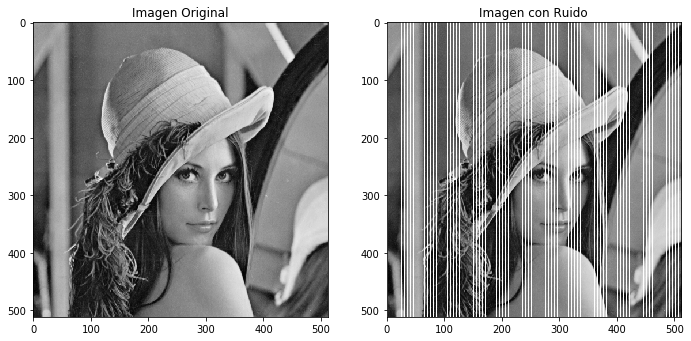

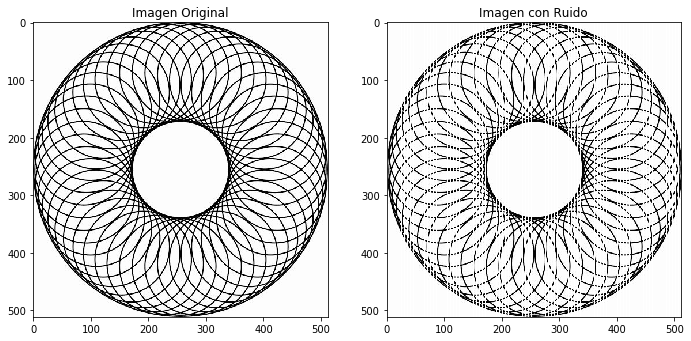

In [22]:
def noisy(img):
    out = np.copy(img)
    for y in range(len(img)):
        for x in range(len(img)):            
            if (y % 5) == 0:
                out[x,y] = 255
    return out


nImg = noisy(img)
plt.figure(1)
plt.subplots_adjust(left=0.0, right=1.5, bottom=0.0, top=1.5)
plt.subplot(121) , plt.imshow(img, cmap='gray')
plt.title('Imagen Original')
plt.subplot(122) , plt.imshow(nImg, cmap='gray')
plt.title('Imagen con Ruido')
plt.show()

nImg2 = noisy(img2)
plt.figure(2)
plt.subplots_adjust(left=0.0, right=1.5, bottom=0.0, top=1.5)
plt.subplot(121) , plt.imshow(img2, cmap='gray')
plt.title('Imagen Original')
plt.subplot(122) , plt.imshow(nImg2, cmap='gray')
plt.title('Imagen con Ruido')
plt.show()


<h1 style="font-size:150%; color:blue; text-align:left; line-height:45px;"> 2.3.1 Filtrado DCT </h1>

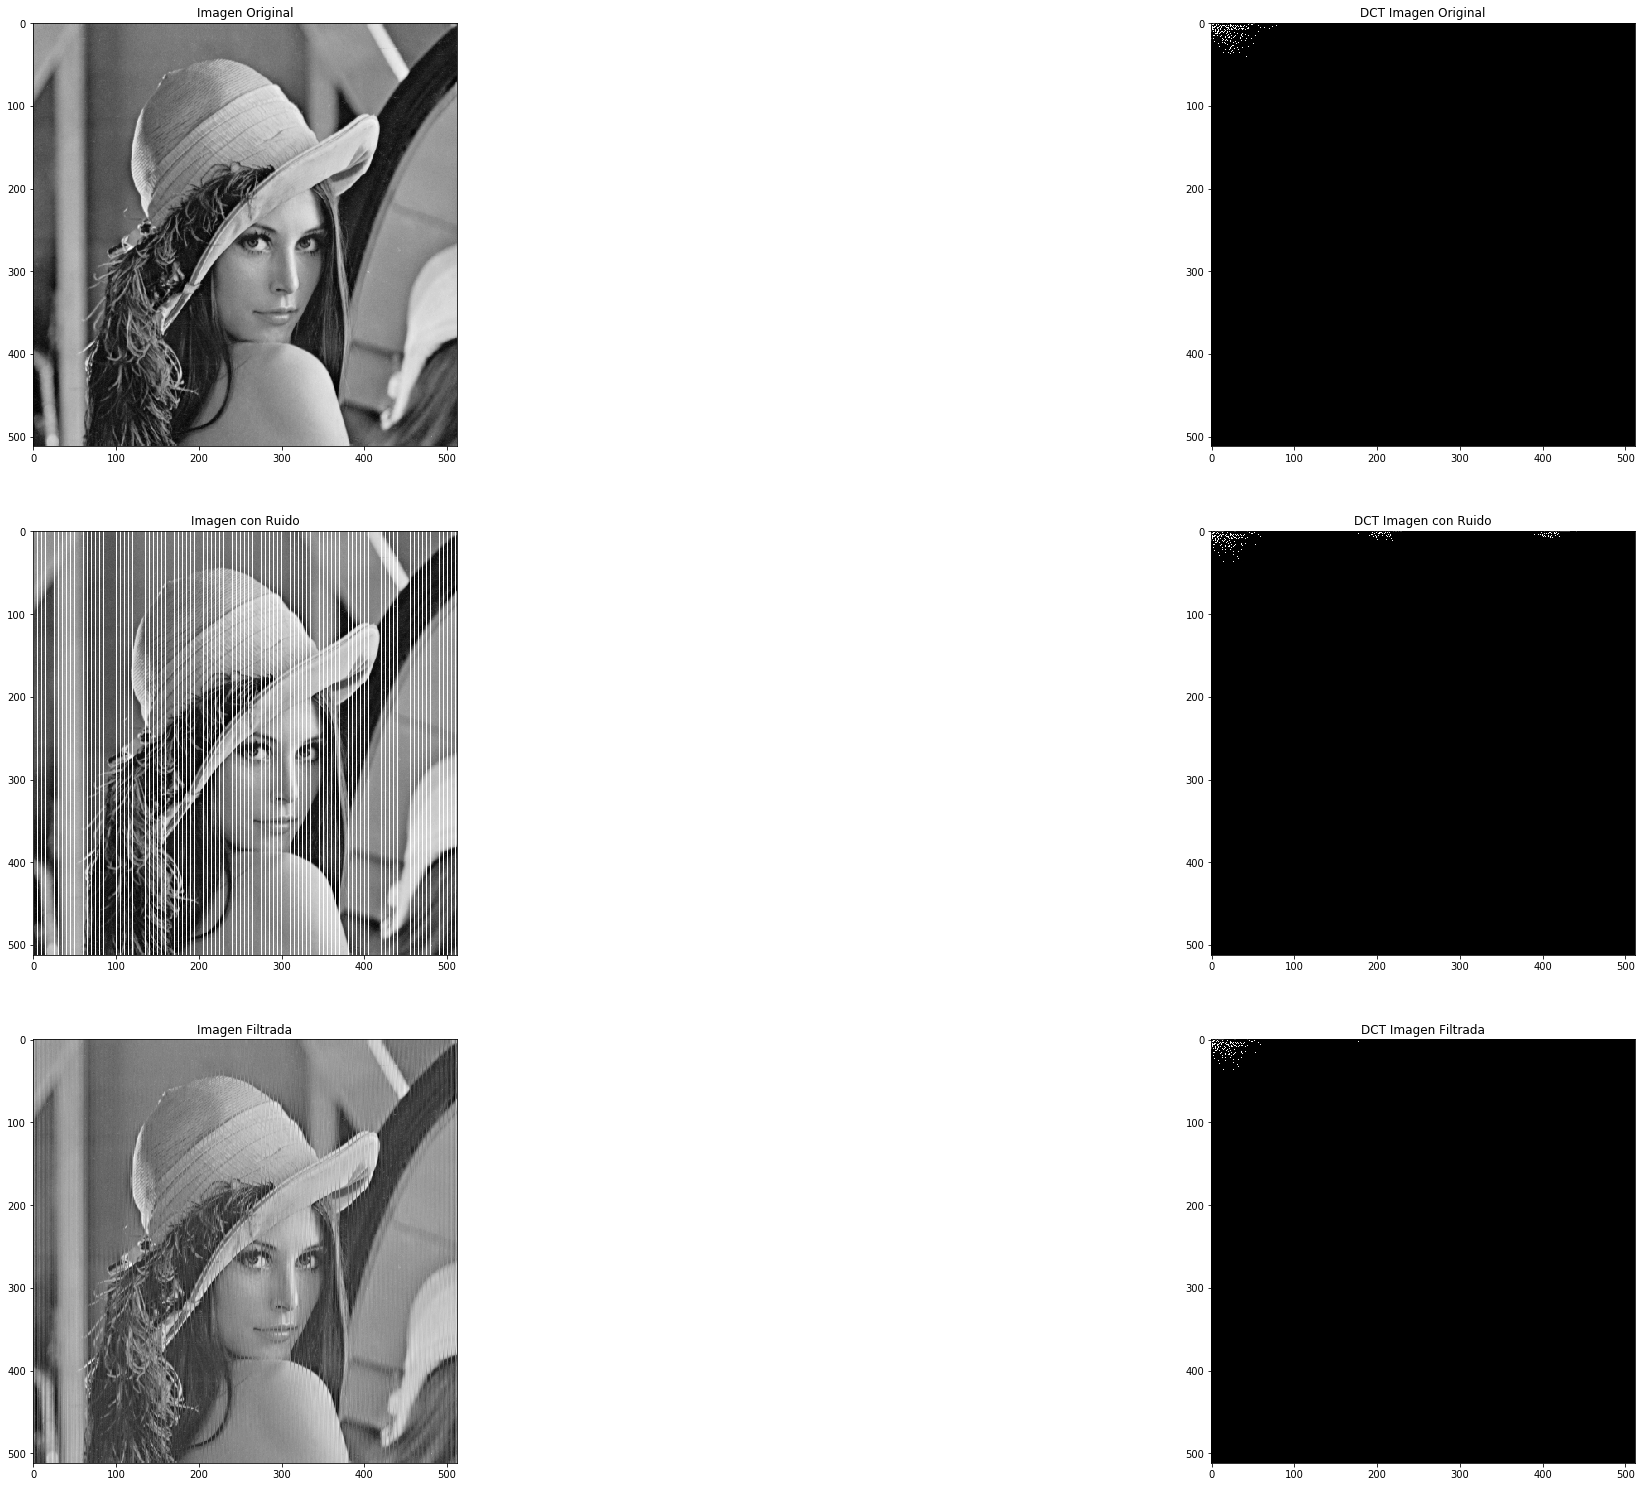

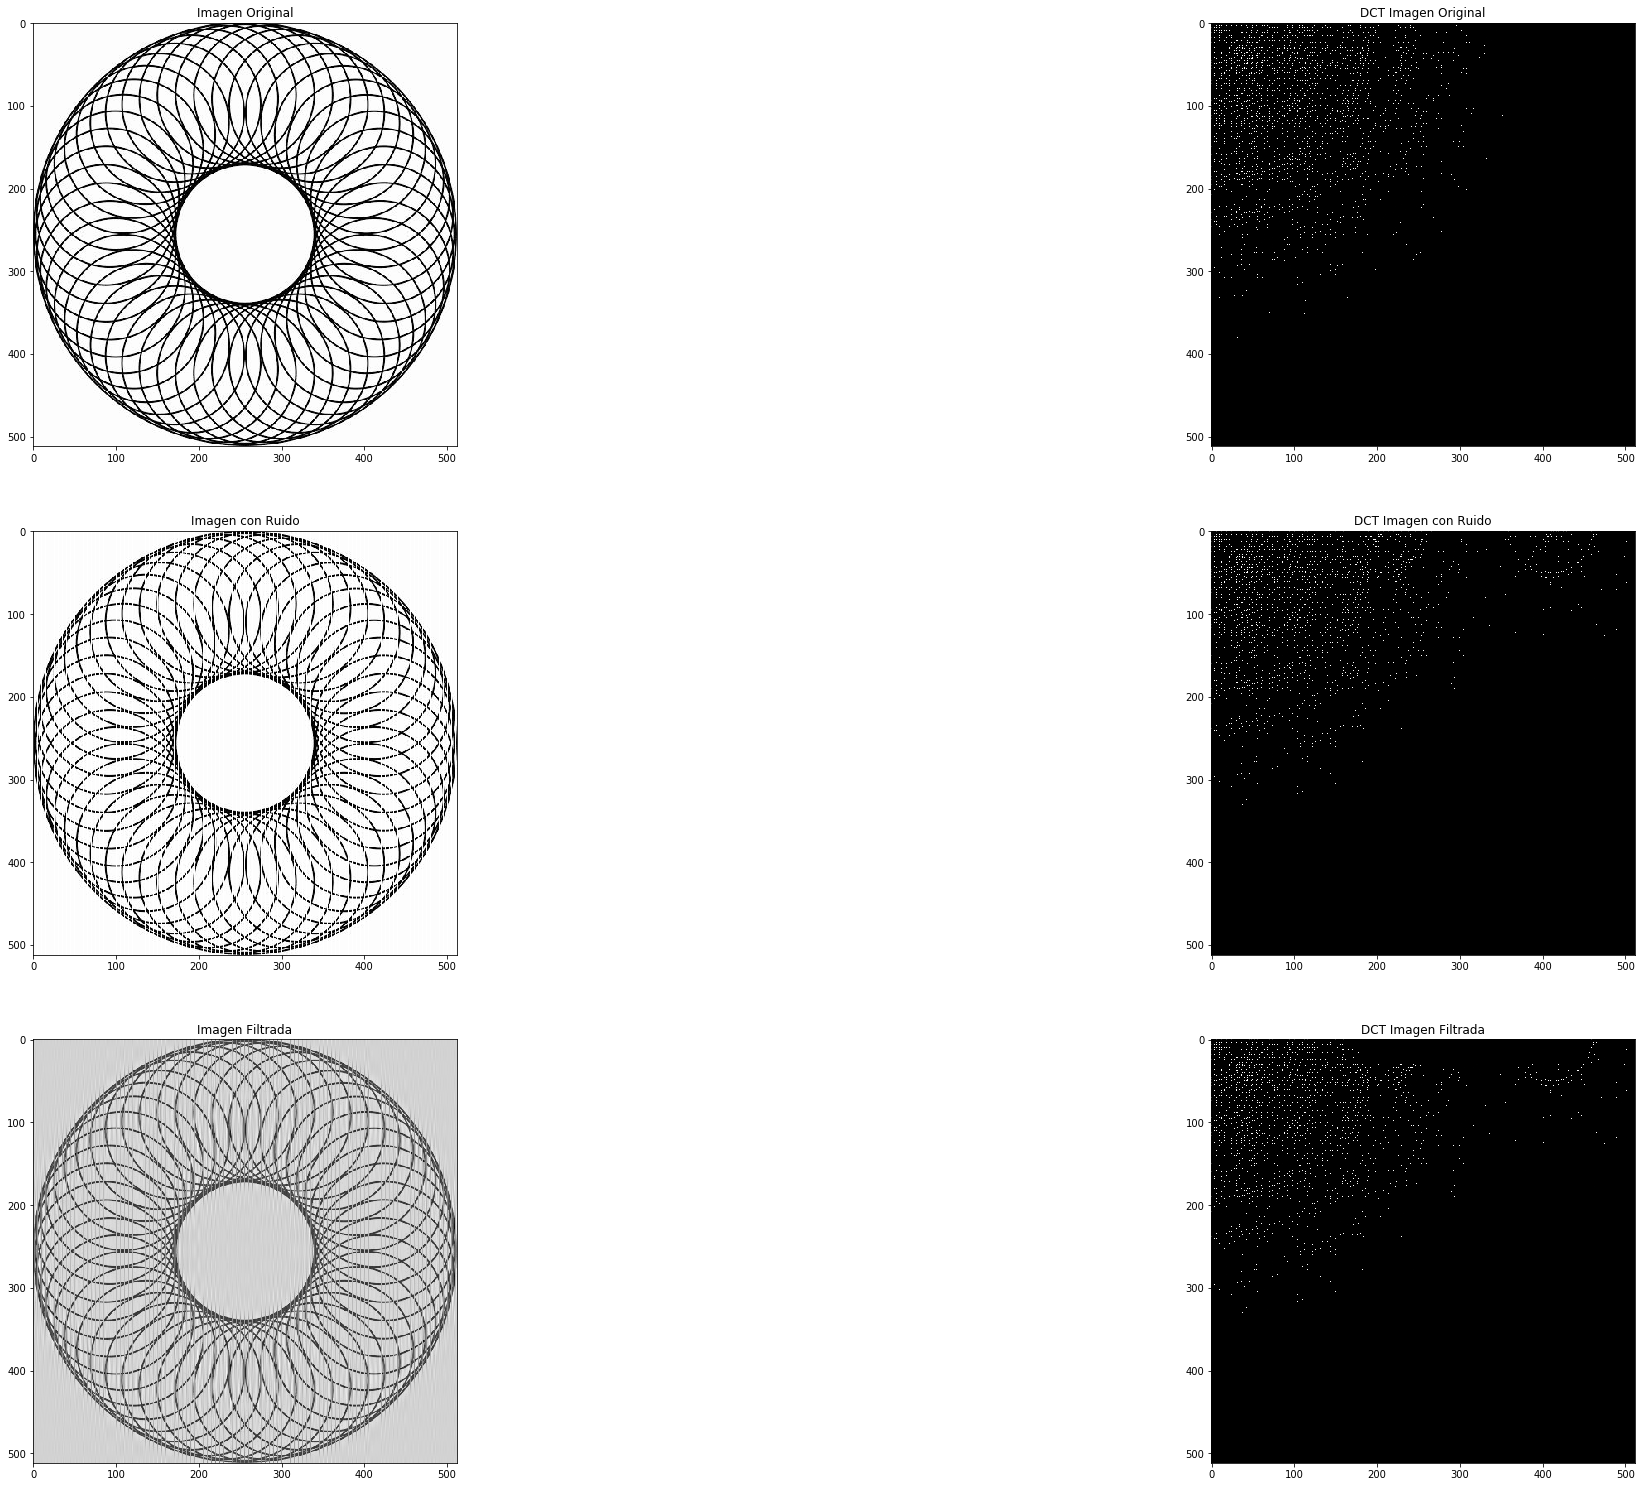

In [25]:
def DCT(img):
    T = np.float32(img)/255.0
    dct = cv2.dct(T)
    odct = np.uint8(dct)*255.0 
    return odct

def fDCT(img, x, y):
    T = np.float32(img)/255.0
    dct = cv2.dct(T)    
    dct[x[0]:x[1],y[0]:y[1]] = 0
    odct = np.uint8(dct)*255.0 
    fImg = cv2.idct(np.float32(dct)/255.0) 
    return fImg, odct

dctImg = DCT(img)
dctNImg = DCT(nImg)
flt, fdct = fDCT(nImg, (0,30), (180,450))

plt.figure(1)
plt.subplots_adjust(left=0.0, right=5.0, bottom=0.0, top=5.0)
plt.subplot(321) , plt.imshow(img, cmap='gray')
plt.title('Imagen Original')
plt.subplot(322) , plt.imshow(dctImg, cmap='gray')
plt.title('DCT Imagen Original')
plt.subplot(323) , plt.imshow(nImg, cmap='gray')
plt.title('Imagen con Ruido')
plt.subplot(324) , plt.imshow(dctNImg, cmap='gray')
plt.title('DCT Imagen con Ruido')
plt.subplot(325) , plt.imshow(flt, cmap='gray')
plt.title('Imagen Filtrada')
plt.subplot(326) , plt.imshow(fdct, cmap='gray')
plt.title('DCT Imagen Filtrada')

dctImg = DCT(img2)
dctNImg = DCT(nImg2)
flt, fdct = fDCT(nImg2, (0,30), (180,450))

plt.figure(2)
plt.subplots_adjust(left=0.0, right=5.0, bottom=0.0, top=5.0)

plt.subplot(321) , plt.imshow(img2, cmap='gray')
plt.title('Imagen Original')
plt.subplot(322) , plt.imshow(dctImg, cmap='gray')
plt.title('DCT Imagen Original')
plt.subplot(323) , plt.imshow(nImg2, cmap='gray')
plt.title('Imagen con Ruido')
plt.subplot(324) , plt.imshow(dctNImg, cmap='gray')
plt.title('DCT Imagen con Ruido')
plt.subplot(325) , plt.imshow(flt, cmap='gray')
plt.title('Imagen Filtrada')
plt.subplot(326) , plt.imshow(fdct, cmap='gray')
plt.title('DCT Imagen Filtrada')

plt.show()




<h1 style="font-size:150%; color:blue; text-align:left; line-height:45px;"> 2.3.2 Filtrado DCT </h1>

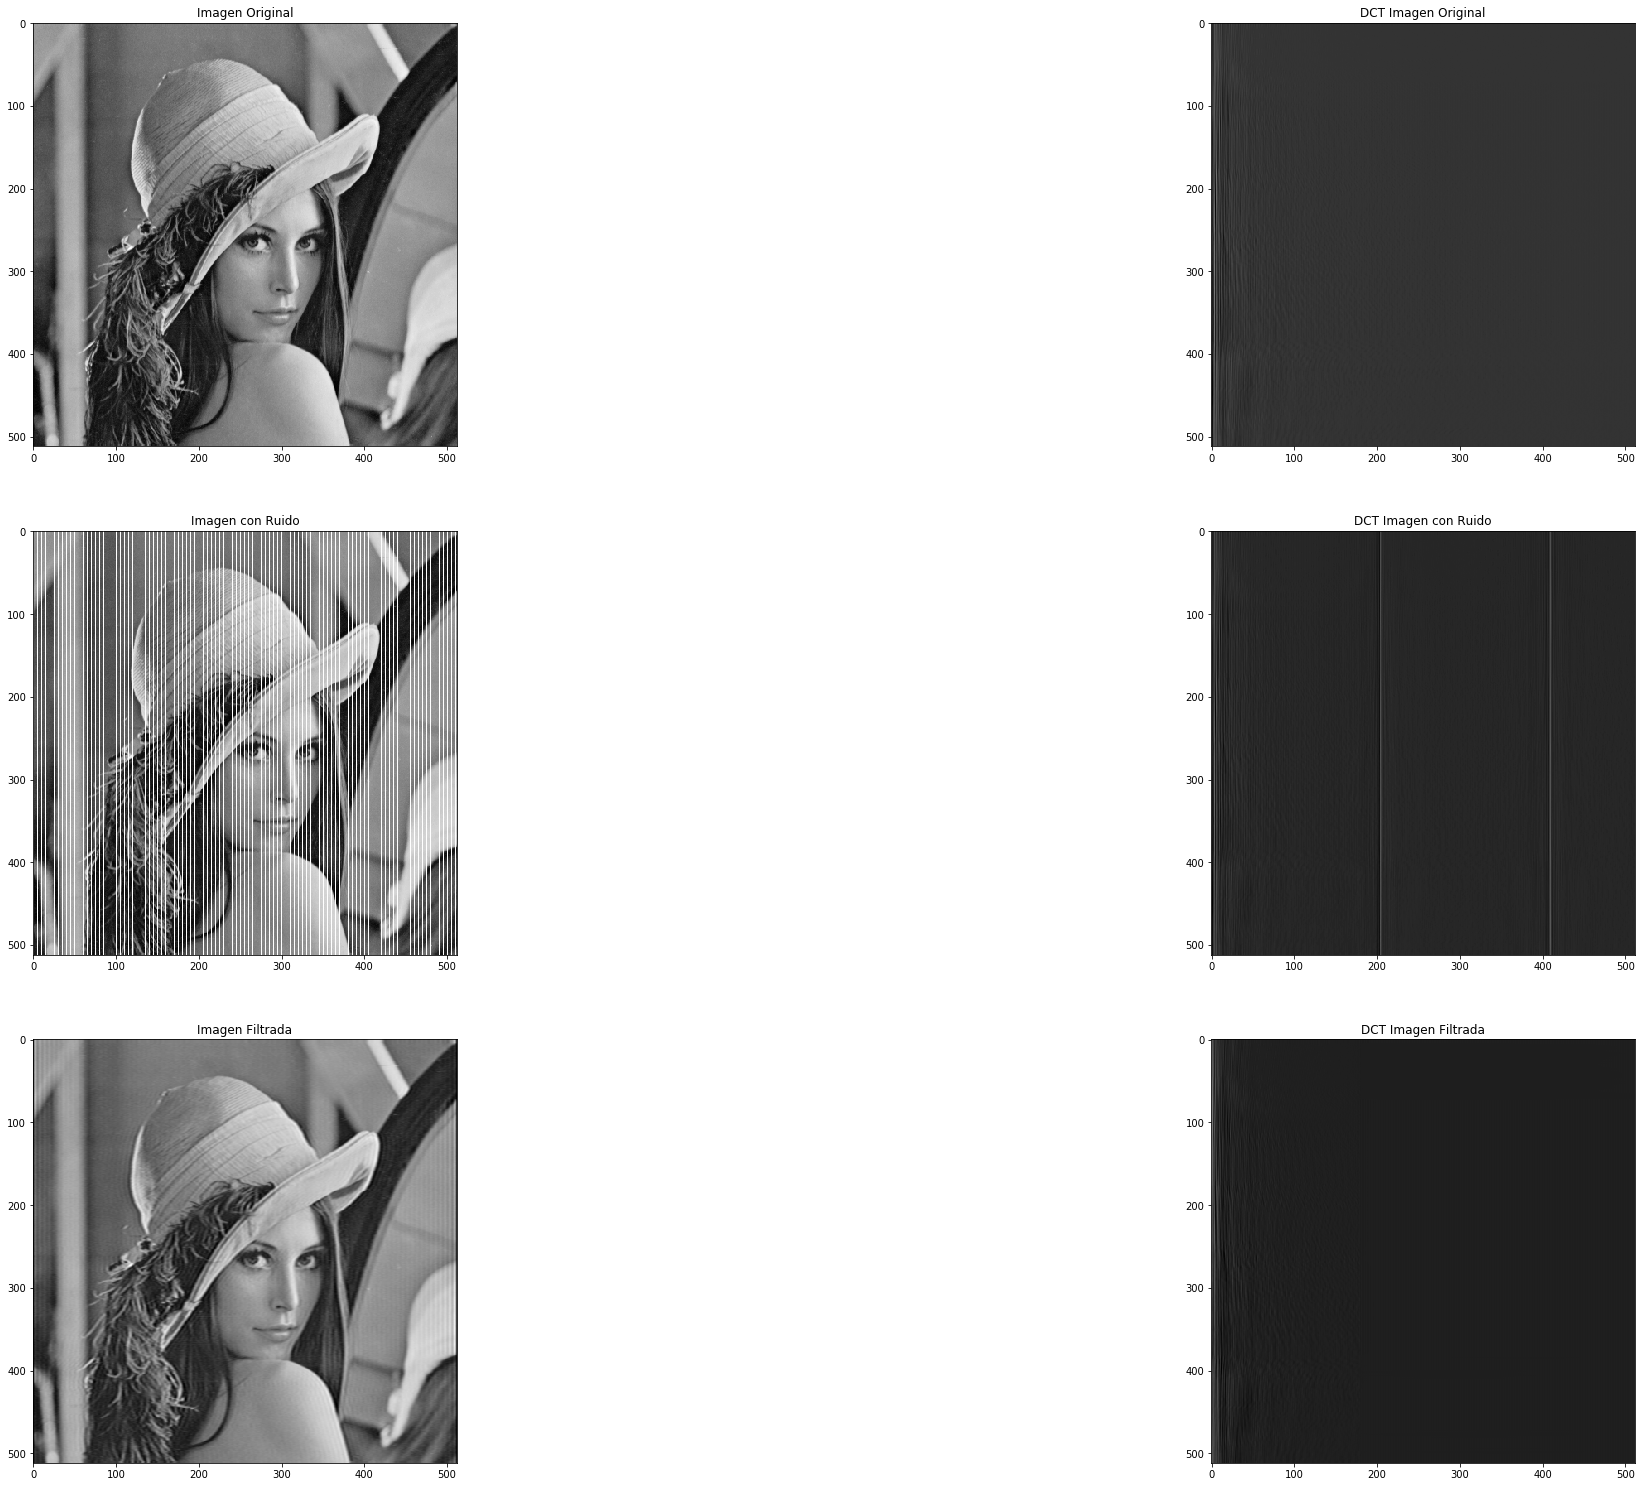

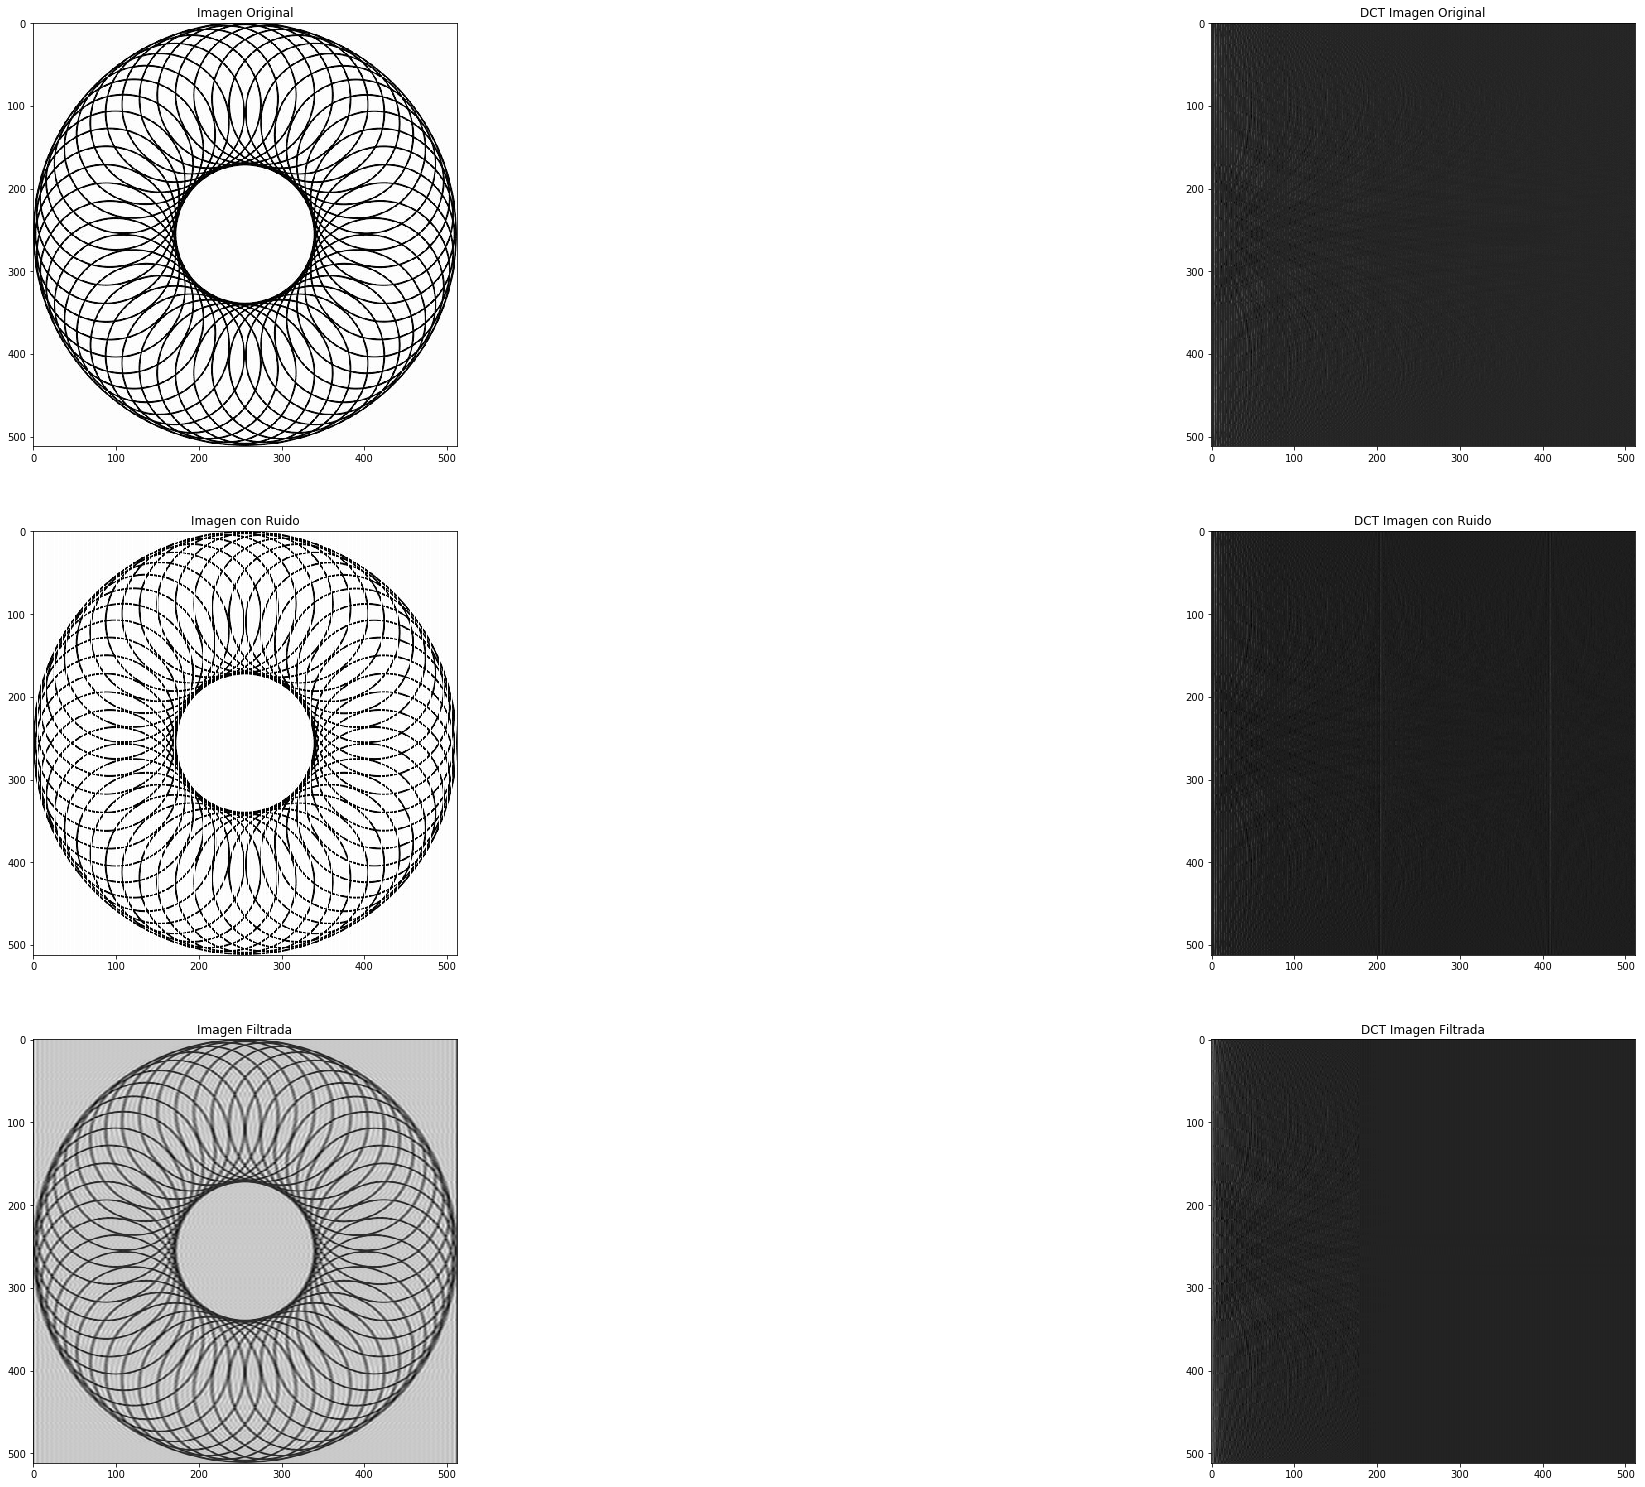

In [65]:
def fDST(img):
    T = dst(img)
    T[0:len(img),180:len(img)] = 0
    return idst(T)

fImg = fDST(img)

plt.figure(1)
plt.subplots_adjust(left=0.0, right=5.0, bottom=0.0, top=5.0)
plt.subplot(321) , plt.imshow(img, cmap='gray')
plt.title('Imagen Original')
plt.subplot(322) , plt.imshow(dst(img), cmap='gray')
plt.title('DCT Imagen Original')
plt.subplot(323) , plt.imshow(nImg, cmap='gray')
plt.title('Imagen con Ruido')
plt.subplot(324) , plt.imshow(dst(nImg), cmap='gray')
plt.title('DCT Imagen con Ruido')
plt.subplot(325) , plt.imshow(fImg, cmap='gray')
plt.title('Imagen Filtrada')
plt.subplot(326) , plt.imshow(idst(fImg), cmap='gray')
plt.title('DCT Imagen Filtrada')

fImg = fDST(img2)

plt.figure(2)
plt.subplots_adjust(left=0.0, right=5.0, bottom=0.0, top=5.0)
plt.subplot(321) , plt.imshow(img2, cmap='gray')
plt.title('Imagen Original')
plt.subplot(322) , plt.imshow(dst(img2), cmap='gray')
plt.title('DCT Imagen Original')
plt.subplot(323) , plt.imshow(nImg2, cmap='gray')
plt.title('Imagen con Ruido')
plt.subplot(324) , plt.imshow(dst(nImg2), cmap='gray')
plt.title('DCT Imagen con Ruido')
plt.subplot(325) , plt.imshow(fImg, cmap='gray')
plt.title('Imagen Filtrada')
plt.subplot(326) , plt.imshow(idst(fImg), cmap='gray')
plt.title('DCT Imagen Filtrada')
plt.show()